# $\color{purple}{\text{HomeWork 2: Classifying digits \& learning theory}} $

--- 




## $\color{purple}{\text{Classifying digits with Scikit-learn}}$
--- 

We are going to use the UCI ML handwritten digits datasets, which can be found also on [this website](https://archive.ics.uci.edu/ml/datasets/semeion+handwritten+digit).

### 1) Import and prepare the data

In [1]:
#We import the usual packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits

X,y_raw = load_digits(return_X_y=True)
n = len(X)
d = len(X[0])
p_min = X.min()
p_max = X.max()
y_min=y_raw.min()
y_max=y_raw.max()

print(f'The dataset contains {n} images, each being a set of {d} pixels that can take integer values from {p_min} to {p_max}.')
print(f'Each image represents an handwritten digit, that can be from {y_min} to {y_max}.')

The dataset contains 1797 images, each being a set of 64 pixels that can take integer values from 0.0 to 16.0.
Each image represents an handwritten digit, that can be from 0 to 9.


Now, since we want to design a classifier that distinguishes odd numbers from even ones, we need to change the labels in such a way that all the even numbers will correspond to $y=0$ and all the odd numbers will correspond to $y=1$. This can be done easily with just one line of code

In [3]:
y = np.array([i%2 for i in y_raw])

n_even = len(y[y==0])
n_odd = len(y[y==1])
print(f'The dataset contains {n} images, {n_even} of them are even and {n_odd} are odd.')

The dataset contains 1797 images, 891 of them are even and 906 are odd.


Next, we want to split the data into 60% for training and 40% for testing. Furthermore, we want to check that each number (from 0 to 9) is present proportionally in both the subsets. Again, this is really easy if we know which tools to use

In [4]:
from sklearn.model_selection import train_test_split

indices = range(0,len(y))
XTrain, XTest, yTrain, yTest, iTrain, iTest = train_test_split(X,y,indices, test_size = 0.4, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  1078
Testing  Samples:  719


We introduced the array `indices` so that we can check that the initial labels are proportionally distributed between the two subsets

In [5]:
for num in range(y_max+1):
  print(f'There are {sum(np.array([y_raw[i]==num for i in iTrain]))} number {num}s in the Training set and {sum(np.array([y_raw[i]==num for i in iTest]))} in the Test set')

There are 104 number 0s in the Training set and 74 in the Test set
There are 114 number 1s in the Training set and 68 in the Test set
There are 109 number 2s in the Training set and 68 in the Test set
There are 100 number 3s in the Training set and 83 in the Test set
There are 102 number 4s in the Training set and 79 in the Test set
There are 117 number 5s in the Training set and 65 in the Test set
There are 111 number 6s in the Training set and 70 in the Test set
There are 105 number 7s in the Training set and 74 in the Test set
There are 112 number 8s in the Training set and 62 in the Test set
There are 104 number 9s in the Training set and 76 in the Test set


### 2) Logistic regression

We start by considering Logistic regression, both with an $l1$ and an $l2$ penalty, choosing the `solver` that is faster to converge

In [6]:
from sklearn import linear_model
regL1= linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=1) #liblinear is way faster than saga
regL2= linear_model.LogisticRegression(penalty='l2', max_iter=10000, C=1)

In [7]:
#--- Define the Parameters to Search ---#
table_C = np.logspace(-4,1,31)
param_grid = [
    {'C': table_C} 
]

We then move to define, as always, our Cross Validation strategy. Scecifically, we are creating 5 splits from the original Training set using `ShuffleSplit` and then we pass these subsets to `GridSearchCV`, that allows us to estimate the score for each of the values of the parameter $C$ we chose.

In [8]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV

#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
cv_L1 = GridSearchCV(regL1, param_grid, cv=cv, return_train_score=True)
cv_L2 = GridSearchCV(regL2, param_grid, cv=cv, return_train_score=True)

In [9]:
%%timeit
cv_L1.fit(XTrain,yTrain)

1.48 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
cv_L2.fit(XTrain,yTrain)

13.5 s ± 625 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


After having fitted the parameters corresponding to the classificators for each $C$, we save as `cv_Opt` the optimal classificator and we store in `cv_optC` the respective parameter $C$

In [12]:
cv_OptC_L1 = cv_L1.cv_results_['param_C'][cv_L1.best_index_]
cv_OptC_L2 = cv_L2.cv_results_['param_C'][cv_L2.best_index_]
L1_Opt = cv_L1.best_estimator_
L2_Opt = cv_L2.best_estimator_

print('The optimal parameter C found by CV is {:.3f} for l1 penalty and {:.3f} for l2 penalty'.format(cv_OptC_L1,cv_OptC_L2))

The optimal parameter C found by CV is 0.147 for l1 penalty and 0.003 for l2 penalty


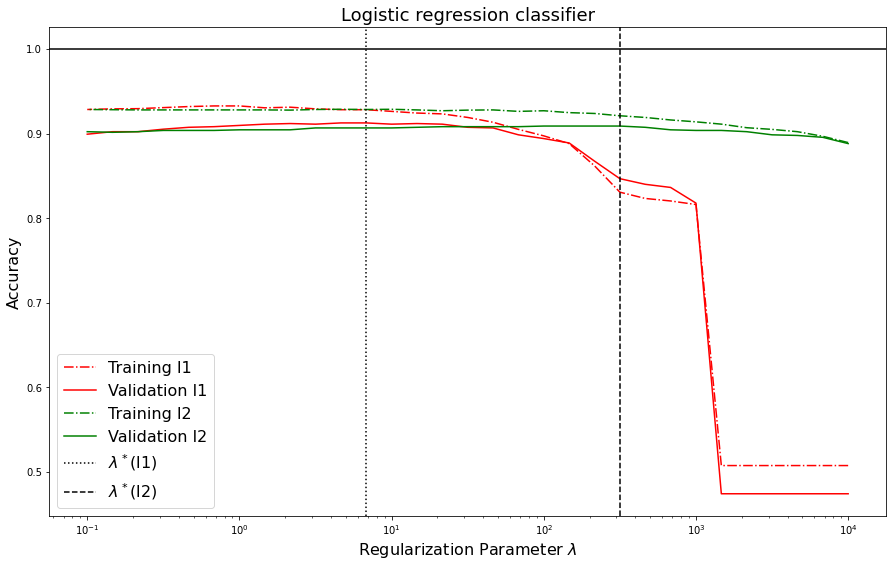

In [13]:
trainScores_L1 = cv_L1.cv_results_['mean_train_score'] 
testScores_L1 = cv_L1.cv_results_['mean_test_score']   

trainScores_L2 = cv_L2.cv_results_['mean_train_score'] 
testScores_L2 = cv_L2.cv_results_['mean_test_score']   

plt.figure(figsize=(15,9))
plt.title('Logistic regression classifier', fontsize=18)
plt.plot([1/i for i in table_C], trainScores_L1, 'r-.', label='Training l1')
plt.plot([1/i for i in table_C], testScores_L1, 'r-', label='Validation l1')
plt.plot([1/i for i in table_C], trainScores_L2, 'g-.', label='Training l2')
plt.plot([1/i for i in table_C], testScores_L2, 'g-', label='Validation l2')
plt.xlabel('Regularization Parameter $\\lambda$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.axvline(1/cv_OptC_L1, label='$\\lambda^* $(l1)', color='k', linestyle=':')
plt.axvline(1/cv_OptC_L2, label='$\\lambda^* $(l2)', color='k', linestyle='--')
plt.axhline(1, color='k', linestyle='-')
plt.xscale('log')
plt.legend(loc='best', fontsize=16)

Finally, we can see the performance of the two classifiers on the Test set

In [14]:
print(f'The Accuracy' + " computed on the Test set is {:.3f} for the l1 penalty and {:.3f} for the l2 penalty".format(L1_Opt.score(XTest,yTest), L2_Opt.score(XTest,yTest)))

The Accuracy computed on the Test set is 0.924 for the l1 penalty and 0.924 for the l2 penalty


### 3a) Ridge

We then move to the Ridge regression classifier

In [ ]:
regRR= linear_model.RidgeClassifier(alpha=1) 

In [ ]:
#--- Define the Parameters to Search ---#
table_alpha = np.logspace(1,7,61)
param_grid = [
    {'alpha': table_alpha} 
]

Again, we perform Cross Validation

In [ ]:
cv_RR= GridSearchCV(regRR, param_grid, cv=cv, return_train_score=True)

In [ ]:
%%timeit
cv_RR.fit(XTrain,yTrain)

1 loop, best of 5: 2.54 s per loop


After having fitted the parameters corresponding to the classificators for each $\lambda$, we save as `cv_Opt` the optimal classificator and we store in `cv_optC` the respective parameter $\lambda$

In [ ]:
cv_Optalpha_RR = cv_RR.cv_results_['param_alpha'][cv_RR.best_index_]
RR_Opt = cv_RR.best_estimator_

print('The optimal parameter lambda found by CV is {:.3f}'.format(cv_Optalpha_RR))

The optimal parameter lambda found by CV is 3981.072


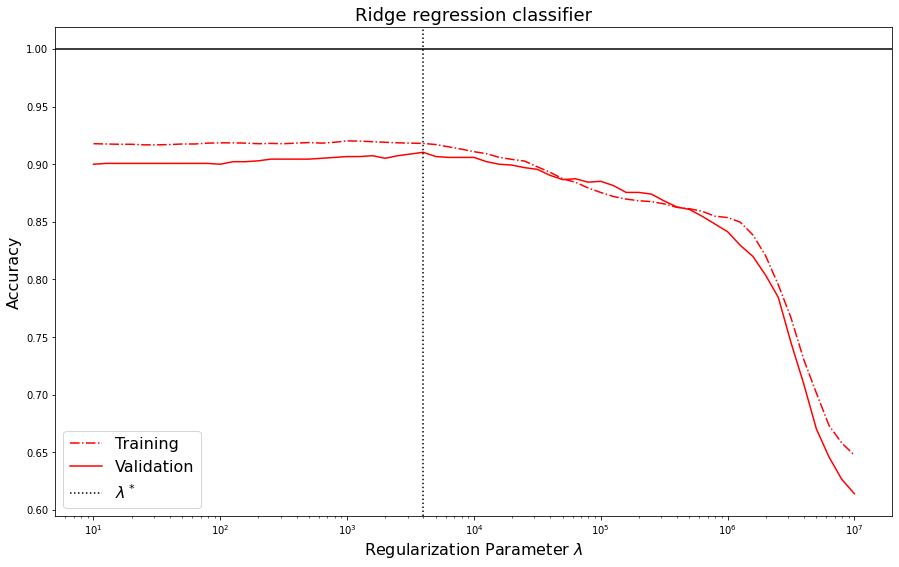

In [ ]:
trainScores_RR = cv_RR.cv_results_['mean_train_score'] 
testScores_RR = cv_RR.cv_results_['mean_test_score']   
plt.figure(figsize=(15,9))
plt.title('Ridge regression classifier', fontsize=18)
plt.plot( table_alpha, trainScores_RR, 'r-.', label='Training')
plt.plot(table_alpha, testScores_RR, 'r-', label='Validation')
plt.xlabel('Regularization Parameter $\\lambda$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.axvline(cv_Optalpha_RR, label='$\\lambda^* $', color='k', linestyle=':')
plt.axhline(1, color='k', linestyle='-')
plt.xscale('log')
plt.legend(loc='best', fontsize=16)

Finally, we can see the performance of the classifier on the Test set

In [ ]:
print(f'The Accuracy' + " computed on the Test set is {:.3f}".format(RR_Opt.score(XTest,yTest)))

The Accuracy computed on the Test set is 0.911


### 3b) Hinge

Let's take into consideration Hinge regression now, both with $l1$ and $l2$ penalty

In [ ]:
from sklearn import svm

In [ ]:
regH1= svm.LinearSVC(penalty='l1', C=1., dual= False)
regH2= svm.LinearSVC(penalty='l2', C=1., tol=0.1, max_iter=100000)

In [ ]:
#--- Define the Parameters to Search ---#
table_C = np.logspace(-4,0,25)
param_grid = [
    {'C': table_C} 
]

In [ ]:
#--- Define CV Splitting ---#
cv_H1 = GridSearchCV(regH1, param_grid, cv=cv, return_train_score=True)

In [ ]:
cv_H2 = GridSearchCV(regH2, param_grid, cv=cv, return_train_score=True)

In [ ]:
%%timeit
cv_H1.fit(XTrain,yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1 loop, best of 5: 11.6 s per loop


In [ ]:
%%timeit
cv_H2.fit(XTrain,yTrain)

1 loop, best of 5: 22.9 s per loop


After having fitted the parameters corresponding to the classificators for each $C$, we save as `cv_Opt` the optimal classificator and we store in `cv_optC` the respective parameter $C$

In [ ]:
cv_OptC_H1 = cv_H1.cv_results_['param_C'][cv_H1.best_index_]
cv_OptC_H2 = cv_H2.cv_results_['param_C'][cv_H2.best_index_]
H1_Opt = cv_H1.best_estimator_
H2_Opt = cv_H2.best_estimator_

print('The optimal parameter C found by CV is {:.3f} for l1 penalty and {:.3f} for l2 penalty'.format(cv_OptC_H1,cv_OptC_H2))

The optimal parameter C found by CV is 0.068 for l1 penalty and 0.005 for l2 penalty


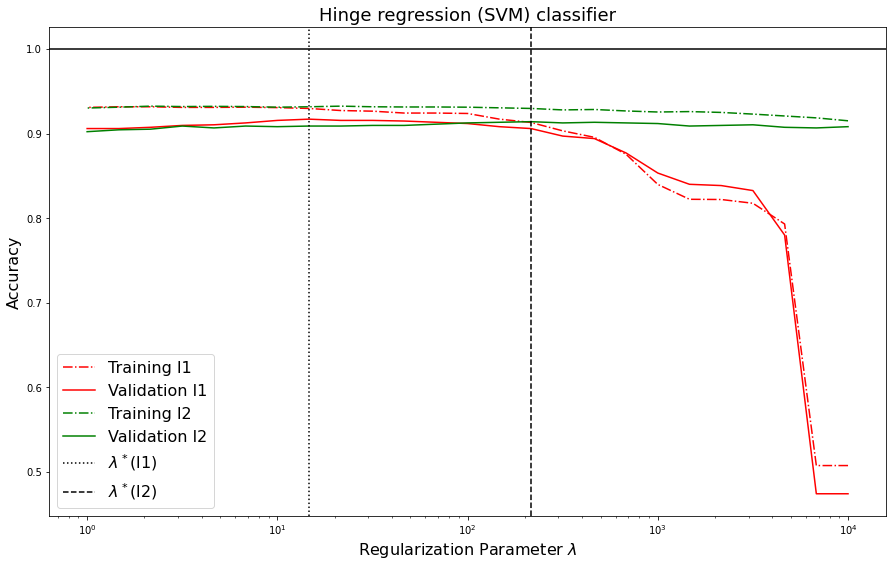

In [ ]:
trainScores_H1 = cv_H1.cv_results_['mean_train_score'] 
testScores_H1 = cv_H1.cv_results_['mean_test_score']   

trainScores_H2 = cv_H2.cv_results_['mean_train_score'] 
testScores_H2 = cv_H2.cv_results_['mean_test_score']   

plt.figure(figsize=(15,9))
plt.title('Hinge regression (SVM) classifier', fontsize=18)
plt.plot([1/i for i in table_C], trainScores_H1, 'r-.', label='Training l1')
plt.plot([1/i for i in table_C], testScores_H1, 'r-', label='Validation l1')
plt.plot([1/i for i in table_C], trainScores_H2, 'g-.', label='Training l2')
plt.plot([1/i for i in table_C], testScores_H2, 'g-', label='Validation l2')
plt.xlabel('Regularization Parameter $\\lambda$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.axvline(1/cv_OptC_H1, label='$\\lambda^* $(l1)', color='k', linestyle=':')
plt.axvline(1/cv_OptC_H2, label='$\\lambda^* $(l2)', color='k', linestyle='--')
plt.axhline(1, color='k', linestyle='-')
plt.xscale('log')
plt.legend(loc='best', fontsize=16)

Finally, we can see the performance of the two classifiers on the Test set

In [ ]:
print(f'The Accuracy' + " computed on the Test set is {:.3f} for the l1 penalty and {:.3f} for the l2 penalty".format(H1_Opt.score(XTest,yTest), H2_Opt.score(XTest,yTest)))

The Accuracy computed on the Test set is 0.921 for the l1 penalty and 0.921 for the l2 penalty


### 4) Random forest classifier 

Let us consider now a Random forest classifier and let us tune the hyperparameter *n_estimators*, i.e. the number of estimators used in the ensembling process. 

In [54]:
from sklearn.ensemble import RandomForestClassifier

rfo_clf = RandomForestClassifier(max_depth=10, n_estimators= 100, random_state=0)

In [65]:
table_n_estims = np.logspace(1,4,num = 10, base = 10).astype(int)
param_grid = [
    {'n_estimators': table_n_estims} 
]

In [66]:
cv_rfo = GridSearchCV(rfo_clf, param_grid, cv=cv, return_train_score=True)

In [67]:
cv_rfo

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=RandomForestClassifier(max_depth=10, random_state=0),
             param_grid=[{'n_estimators': array([   10,    21,    46,   100,   215,   464,  1000,  2154,  4641,
       10000])}],
             return_train_score=True)

After having fitted the parameters corresponding to the classificators for each number of estimator used, we save as `cv_Opt` the optimal classificator and we store in `cv_optn` the respective parameter of *number of estimators*.


In [68]:
%%timeit
cv_rfo.fit(XTrain,yTrain)

2min 26s ± 14.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
cv_Optn_rfo = cv_rfo.cv_results_['param_n_estimators'][cv_rfo.best_index_]
rfo_Opt = cv_rfo.best_estimator_


print('The optimal parameter max_depth found by CV is {:.3f}'.format(cv_Optn_rfo))

The optimal parameter max_depth found by CV is 4641.000


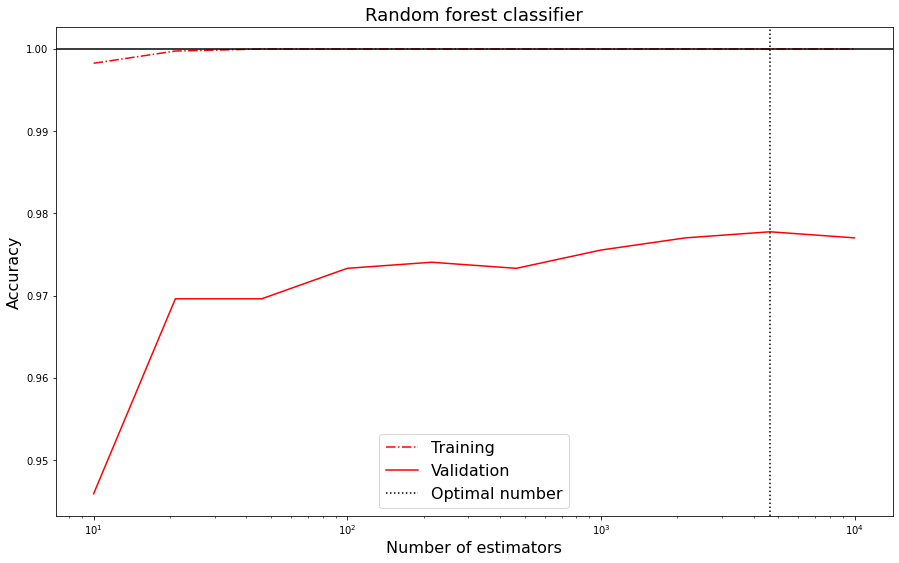

In [76]:
trainScores_rfo = cv_rfo.cv_results_['mean_train_score'] 
testScores_rfo = cv_rfo.cv_results_['mean_test_score']   


plt.figure(figsize=(15,9))
plt.title('Random forest classifier', fontsize=18)
plt.plot([i for i in table_n_estims], trainScores_rfo, 'r-.', label='Training')
plt.plot([i for i in table_n_estims], testScores_rfo, 'r-', label='Validation')
plt.xlabel('Number of estimators', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.axvline(cv_Optn_rfo, label='Optimal number', color='k', linestyle=':')
plt.axhline(1, color='k', linestyle='-')
plt.xscale('log')
plt.legend(loc='best', fontsize=16)

### 5) Random Features


In [ ]:
n_RF=4
table_D = np.array([i*d for i in np.logspace(0,n_RF, n_RF+1, base=2, dtype='int') ])
table_F = [ np.random.normal(0,1/d,(D,d)) for D in table_D]

In [ ]:
table_fx = [ np.array([ np.dot(F,x) for x in X]) for F in table_F]

In [ ]:
table_U = [ np.array([ np.array([ 1/((np.sqrt(table_D[j]))*(1+np.e**(-i))) for i in x ]) for x in fx]) for j,fx in enumerate(table_fx)]

In [ ]:
from sklearn.model_selection import train_test_split
table_XTrain = [np.zeros_like(XTrain) for _ in range(len(table_U))]
table_XTest = [np.zeros_like(XTrain) for _ in range(len(table_U))]
table_yTrain = [np.zeros_like(XTrain) for _ in range(len(table_U))]
table_yTest = [np.zeros_like(XTrain) for _ in range(len(table_U))]
for i, U in enumerate(table_U):
  table_XTrain[i], table_XTest[i], table_yTrain[i], table_yTest[i] = train_test_split(U,y,test_size = 0.4, random_state=1)

#### Logistic regression

In [ ]:
regL2U= linear_model.LogisticRegression(penalty='l2', max_iter=10000, C=1)

In [ ]:
#--- Define the Parameters to Search ---#
table_C = np.logspace(2,7,31)
param_grid = [
    {'C': table_C} 
]

In [ ]:
#--- Define CV Splitting ---#
cv_L2U = GridSearchCV(regL2U, param_grid, cv=cv, return_train_score=True)

In [ ]:
j=0

In [ ]:
%%timeit
cv_L2U.fit(table_XTrain[j],table_yTrain[j])

1 loop, best of 5: 1min 14s per loop


After having fitted the parameters corresponding to the classificators for each $C$, we save as `cv_Opt` the optimal classificator and we store in `cv_optC` the respective parameter $C$

In [ ]:
cv_OptC_L2U = cv_L2U.cv_results_['param_C'][cv_L2U.best_index_]
L2U_Opt = cv_L2U.best_estimator_

print('The optimal parameter C found by CV is {:.3f}'.format(cv_OptC_L2U))

The optimal parameter C found by CV is 31622.777


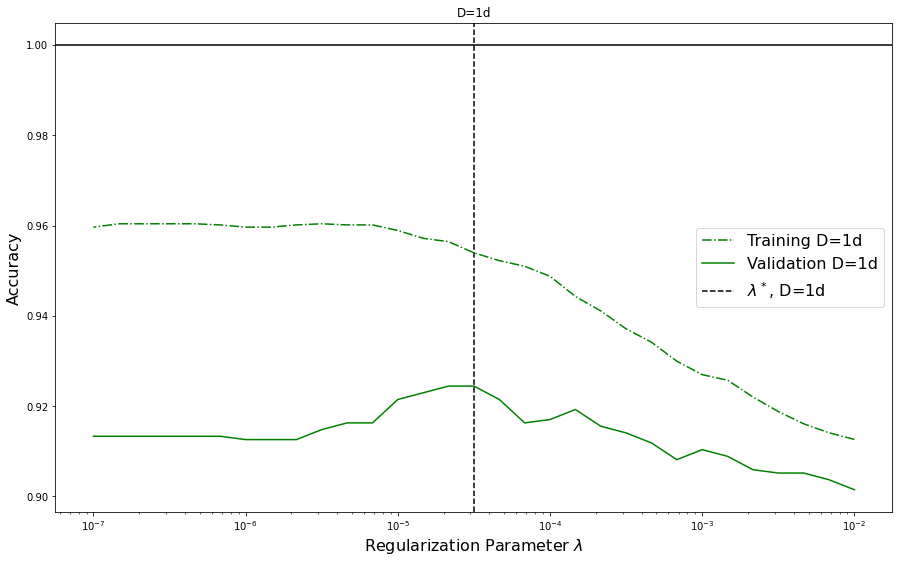

In [ ]:
trainScores_L2U = cv_L2U.cv_results_['mean_train_score'] 
testScores_L2U = cv_L2U.cv_results_['mean_test_score']   

plt.figure(figsize=(15,9))
plt.title('Logistic regression classifier with Random Features', fontsize=18)
plt.plot([1/i for i in table_C], trainScores_L2U, 'g-.', label='Training D={}d'.format(2**j))
plt.plot([1/i for i in table_C], testScores_L2U, 'g-', label='Validation D={}d'.format(2**j))
plt.xlabel('Regularization Parameter $\\lambda$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.axvline(1/cv_OptC_L2U, label='$\\lambda^* $, D={}d'.format(2**j), color='k', linestyle='--')
plt.axhline(1, color='k', linestyle='-')
plt.title(r'D={}d'.format(2**j))
plt.xscale('log')
plt.legend(loc='best', fontsize=16)

Finally, we can see the performance of the classifier on the Test set

In [ ]:
print(f'Accuracy for D={2**j}' + "d, computed on the Test set is {:.3f}".format(L2U_Opt.score(table_XTest[j],table_yTest[j])))

Accuracy for D=1d, computed on the Test set is 0.940


Now we repeat the analysis for higher values of $D$

The optimal parameter C found by CV is 31622.777
The Accuracy for D=1d, computed on the Test set is 0.940
The optimal parameter C found by CV is 1000000.000
The Accuracy for D=2d, computed on the Test set is 0.949
The optimal parameter C found by CV is 10000000.000
The Accuracy for D=4d, computed on the Test set is 0.969
The optimal parameter C found by CV is 2154434.690
The Accuracy for D=8d, computed on the Test set is 0.968
The optimal parameter C found by CV is 6812920.691
The Accuracy for D=16d, computed on the Test set is 0.972


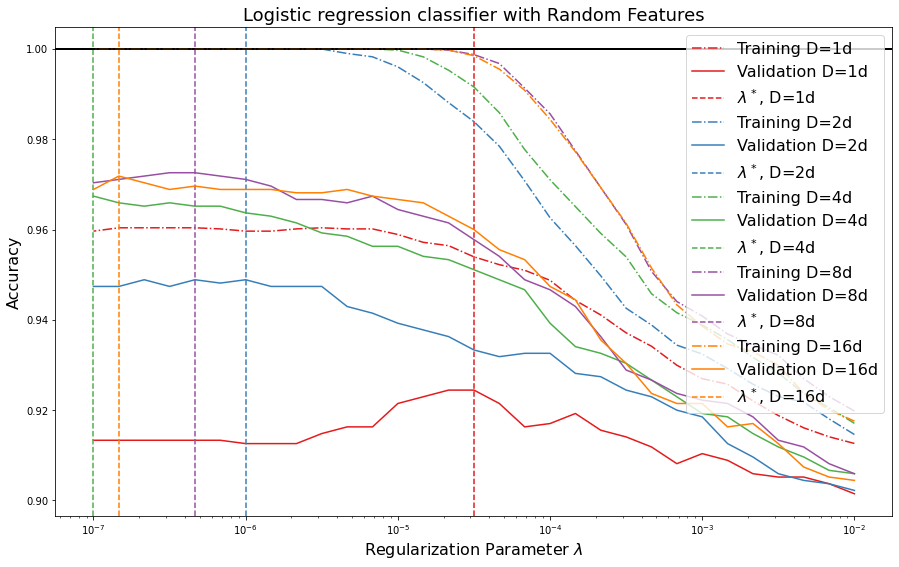

In [ ]:
plt.figure(figsize=(15,9))
for j in range(5):
  cv_L2U.fit(table_XTrain[j],table_yTrain[j])
  cv_OptC_L2U = cv_L2U.cv_results_['param_C'][cv_L2U.best_index_]
  L2U_Opt = cv_L2U.best_estimator_
  print('The optimal parameter C found by CV is {:.3f}'.format(cv_OptC_L2U))
  trainScores_L2U = cv_L2U.cv_results_['mean_train_score'] 
  testScores_L2U = cv_L2U.cv_results_['mean_test_score']   
  plt.plot([1/i for i in table_C], trainScores_L2U, color=plt.cm.Set1(j), linestyle='-.', label='Training D={}d'.format(2**j))
  plt.plot([1/i for i in table_C], testScores_L2U, color=plt.cm.Set1(j), linestyle='-', label='Validation D={}d'.format(2**j))
  plt.xlabel('Regularization Parameter $\\lambda$', fontsize=16)
  plt.ylabel('Accuracy', fontsize=16)
  plt.axvline(1/cv_OptC_L2U, label='$\\lambda^* $, D={}d'.format(2**j), color=plt.cm.Set1(j), linestyle='--')
  plt.axhline(1, color='k', linestyle='-')
  print(f'The Accuracy for D={2**j}' + "d, computed on the Test set is {:.3f}".format(L2U_Opt.score(table_XTest[j],table_yTest[j])))
plt.title('Logistic regression classifier with Random Features', fontsize=18)
plt.xscale('log')
plt.legend(loc='best', fontsize=16)

## $\color{purple}{\text{Statistical Learning with Nearest-Neighbors}}$
--- 

### $\color{purple}{\text{Question 1}}$
--- 

 Show that the "best" estimator $f(X)$ in terms of minimizing the expected population  risk $\mathbb E_{{\bf X},Y}[(f({\bf X})-Y)^2]$ is given by $f_{\rm Bayes}(\textbf{X}) = \mathbb E(Y|{\bf X})$

Let us first rewrite the expected population risk.

\begin{align}
\mathcal{R}(\hat{Y}) &= \mathbb{E}_{\textbf{X},Y} \left[(Y(\textbf{X})-\hat{Y}(\textbf{X}))^2 \right] \\
&= \mathbb{E}_{\textbf{X}} \left[\mathbb{E}_{Y|\textbf{X}} \left[(Y|\textbf{X} - \hat{Y})^2 \right] \right]
\end{align}

Minimize by differentiating with respect to $\hat{y}$

$\partial_{\hat{Y}}\mathcal{R}(\hat{Y}) =  2\mathbb{E}_{Y|\textbf{X}} \left[Y|\textbf{X} - \hat{Y} \right] = 0$

We recover the results

$\hat{Y_*}(\textbf{X})=f_{\rm Bayes}(\textbf{X}) = \mathbb E(Y|{\bf X})$

### $\color{purple}{\text{Question 2-3}}$
--- 

We are given a set of point ${\bf x}_{1,\ldots,n}$ and their labels $y_{1,\ldots,n}$ and consider the KNN function (where ${\cal N}_k({\bf X})$ is the set of k-nearest neighbors of the point $\bf X$):
\begin{equation}
f_{\rm KNN}({\bf X})= \frac 1k \sum_{i \in {\cal N}_k({\bf X})} y_i  
\end{equation}
 Show that the difference between the expected population risk   (where we also average over the labels $Y_i$, $i=1, \dots, n$) and the Bayes population risks follows a Bias-Variance decomposition.

 * Q2: Show first 
 
 \begin{align}
\Delta \mathcal{R} &= {\cal R}_{\rm KNN} -  {\cal R}_{\rm Bayes}  \\
&={\mathbb E}_{\left\{ Y^{(i)}\right\},{\bf X},Y} 
\left[(Y-f_{\rm KNN}({\bf X}))^2 -  (Y-f_{\rm Bayes}({\bf X}))^2\right]
\\&={b^2} + {\rm v} \\
&b^2 = \mathbb E_{\bf X} 
\left[\left(\frac 1k \sum_{i \in {\cal N}_k({\bf X})}
f_{\rm Bayes}({\bf x}_i) - f_{\rm Bayes}({\bf X})\right)^2\right] \,\,\, {\rm v} = \frac {\sigma^2}k
\end{align}

* Q3: Bound the bias term using Lipschitzness and uniform spacing assumption

$$\Delta \mathcal{R} \le   L^2 \left({\frac kn}\right)^{\frac 2d}  + \frac{\sigma^2}k$$

You should be veryy familiar with the mathematical derivation since has been done in the third lecture: https://www.overleaf.com/project/6146fe5892ff465f326563aa.

Qualitatevely this relation makes sense! 

This is a prototypical example of the general (classical) picture which we call "Bias-variance tradeoff". 

The U-shaped curve which we have as a function of the parameter $k$ is showing us a general rule while trying to fit data with a given model: you should neither underfit the data nor overfit them. 

The best model will not be the most complex one!

### $\color{purple}{\text{Question 4}}$
--- 

Fix the following values: $ L=\sigma=1$

Plot the bound $\Delta \mathcal{R}(k)$ as a function of $k$ for different values of $n,d$ fixed to understand where the optimum $k_*$ will be.

You can play a bit with this code by varying the values of $n$ and $d$.

It seems that $k_*$ is an increasing function of both $n$ and $d$ almost anywhere. You can check it by fixing different values of $(n,d)$ and looking at the value of $k_*$ using the following code.



The optimal number of neighbours to choose in KNN is k*=52


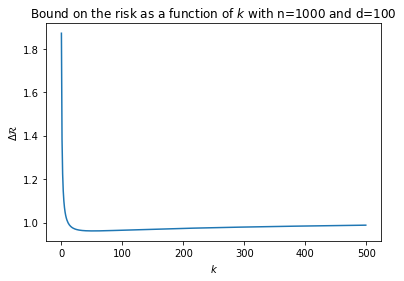

In [13]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
# We will optimize the loglikelyhood with scipy.optimize
import scipy.optimize as so
def f(n,d,k):
  term1 = (k/n)**(2/d) ; term2 = 1/k
  ret = term1 + term2
  return ret

xmin = 1 ; xmax = 500 ; range = 500
ks = np.linspace(xmin,xmax,range) ; d = 100 ; n = 1000
g = [f(n,d,i) for i in ks]
opt = np.argmin(g)
plt.plot(g)
plt.title(f"Bound on the risk as a function of $k$ with n={n} and d={d}")
plt.ylabel("$\Delta \mathcal{R}$")
plt.xlabel("$k$")

print(f"The optimal number of neighbours to choose in KNN is k*={opt}")

Actually although is true that $k_*$ increase with $n$ at fixed $d$ it is not true that $k_*$ is always an increasing function of d, indeed for every $n$ there exists a $d_*(n)$ such that $\partial_{d}k_*(n,d)=0$. 

Nonetheless, when we play with high dimensional datasets we could say that $k_*$ will grow with $d$ safely. You can check this by doing the derivative and see when it changes sign. 

### $\color{purple}{\text{Question 5}}$
--- 

Find analytically $k_*(n,d)$.

Does the relation w.r.t number of samples $n$ makes sense?

$k_* = \text{argmin}_k \,\, f(k,n,d)  \,\,\,\, \text{where} \,\, \Delta \mathcal{R}(k,n,d) \le f(k,n,d)$

$\partial_k f(k,n,d) = \frac{2}{d}(\frac{k}{n})^{\frac{2}{d}-1} - \frac{1}{k^2}$

$k_*(n,d) = \frac{d}{2}^{\frac{d}{d+2}}n^{\frac{2}{d+2}}$

We understand now also from an analytical standpoint the previous numerical consideration: $k_*$ is an increasing function of both parameters with two different rates.

### $\color{purple}{\text{Question 6}}$
--- 

Plug $k_*$ into the risk to find the analytical expression on the bound for $\Delta \mathcal{R}_*$

We can rewrite the derivative of the bound on the risk like this:

$$ \frac{k_*}{n}^{2/d} = \frac{d}{2k_*}$$

We recognize one of the two terms in the bound and we can write:

$$ \Delta \mathcal{R}_* \le f(k_*(n,d),n,d) = \frac{d+2}{2k_*(n,d)} = \frac{d+2}{2(\frac{d}{2}^{\frac{d}{d+2}}n^{\frac{2}{d+2}})}  $$

### $\color{purple}{\text{Question 7}}$
--- 

Fix $\Delta \mathcal{R}_*=0.1$. Why should we worry about how many samples we need?

If you have played with the code, you will have noticed that the value on the y-axis are really high if compare to what we want here: $f(k_*(n,d),n,d) = 0.1$.

We can understand this analytically indeed by the number of samples needed to achieve that bound as a function of the dimension: $n_{0.1}(d)$

By tedious algebra we can find:

$$ n_{0.1}(d) = \frac{(d+2)^{\frac{d+2}{2}}}{(0.2)^{\frac{d+2}{2}}(\frac{d}{2})^{\frac{d}{2}}}$$

This value will be huge! 

If you don't believe it you can play with this code.

Text(0.5, 0, '$d$')

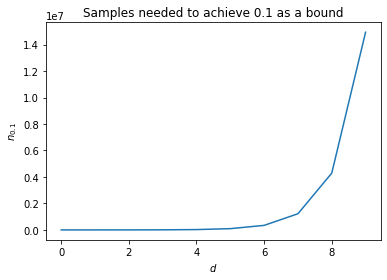

In [ ]:
def f(x):
  term1 = (5*(x+2))**(0.5*(x+2)) ; term2 = (x/2)**(0.5*x)
  ret = term1/term2
  return ret

xmin = 1 ; xmax = 10 ; range = 10
ds = np.linspace(xmin,xmax,range) 
g = [f(i) for i in ds]
plt.plot(g)
plt.title("Samples needed to achieve 0.1 as a bound")
plt.ylabel("$n_{0.1}$")
plt.xlabel("$d$")